<a href="https://colab.research.google.com/github/astroChance/RadNET/blob/master/Post_DL_workbook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and Drive Mount

In [18]:
!pip install --upgrade segyio

import numpy as np
from math import sqrt
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import segyio
import time
import itertools
import os
import re
import random
from PIL import Image
from scipy import spatial, signal
import json
from sklearn.preprocessing import normalize, StandardScaler

# plt.style.use('dark_background')
plt.style.use('classic')

Requirement already up-to-date: segyio in /usr/local/lib/python3.6/dist-packages (1.9.3)


In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [27]:
### DL prediction images
predict_path = "/content/drive/My Drive/RadNET/GAN data/Production_Run1/Predictions/"
InferenceFiles = []
for root, dirs, files in os.walk(predict_path):
    for name in files:
        filename = os.path.join(root, name)
        InferenceFiles.append(filename)

## Corresponding 2D (target) and 3D (input) images
_2D_image_path = "/content/drive/My Drive/RadNET/GAN data/Production_Run1/2D_Production_Min10_Max1_Testing"
ImageFiles_2D = []
for root, dirs, files in os.walk(_2D_image_path):
    for name in files:
        filename = os.path.join(root, name)
        ImageFiles_2D.append(filename)

_3D_image_path = "/content/drive/My Drive/RadNET/GAN data/Production_Run1/3D_Production_Min10_Max1_Testing"
ImageFiles_3D = []
for root, dirs, files in os.walk(_3D_image_path):
    for name in files:
        filename = os.path.join(root, name)
        ImageFiles_3D.append(filename)


InferenceFiles = sorted(InferenceFiles, key=lambda x: int(x.split('/')[-1].split('_')[0]))
ImageFiles_2D = sorted(ImageFiles_2D, key=lambda x: int(x.split('/')[-1].split('_')[0]))
ImageFiles_3D = sorted(ImageFiles_3D, key=lambda x: int(x.split('/')[-1].split('_')[0]))


### SEGY Data filenames
# 3D

Volume3D = "/content/drive/My Drive/RadNET/GAN data/3D/PB3D_Fritz_subset.sgy"

# 2D

_2D_segy_path = "/content/drive/My Drive/RadNET/GAN data/2D"
TwoDFiles = []
for root, dirs, files in os.walk(_2D_segy_path):
    for name in files:
        filename = os.path.join(root, name)
        TwoDFiles.append(filename)


# Load dictionary to get 2D / 3D trace relationships
Trace_Map_Dict = "/content/drive/My Drive/RadNET/GAN data/2D_to_3D_Trace_Dict.json"
with open(Trace_Map_Dict, 'r') as TraceDictFile:
  TraceDict = json.load(TraceDictFile)

In [14]:
print(InferenceFiles[-1])
print(ImageFiles_2D[-1])
print(ImageFiles_3D[-1])

/content/drive/My Drive/RadNET/GAN data/Production_Run1/Predictions/999_2334001000_3D_6870_prediction.png
/content/drive/My Drive/RadNET/GAN data/Production_Run1/2D_Production_Min10_Max1_Testing/999_2334001000_2D_597.png
/content/drive/My Drive/RadNET/GAN data/Production_Run1/3D_Production_Min10_Max1_Testing/999_2334001000_3D_6870.png


# Custom Functions

In [33]:
########
# Griffin Lim implementation

def griffin_lim(magnitude, iterations, orig_sig, fs, nperseg, noverlap, window):
    """
    Inputs:
      magnitude: the real-value spectrogram array to be converted to signal
      iterations: number of iterations to perform Griffin Lim, suggest several hundred -> 1000
      orig_sig: the original time-domain signal prior to enhancement
            -typical GLA uses random initial signal, using original signal improves stability
      fs, nperseg, noverlap, window: parameters from original STFT


    Returns:
      GLA reconstructed time domain signal

    """
    sig_recon = orig_sig

    error = []

    while iterations > 0:
        _, _, temp_spec = signal.stft(sig_recon, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)
        comp_angle = np.angle(temp_spec)
        new_spec = magnitude*np.exp(1j*comp_angle)
        prev_sig = sig_recon
        _, sig_recon = signal.istft(new_spec, window = window, fs = fs, nperseg = nperseg, noverlap=noverlap)

        if iterations % 10 == 0:
            try:
                rmse = sqrt(sum((sig_recon - prev_sig)**2) / prev_sig.size)
                error.append(rmse)
            except ValueError:
                if len(sig_recon) > len(prev_sig):
                    sig_recon_tmp = sig_recon[:len(prev_sig)]
                    rmse = sqrt(sum((sig_recon_tmp - prev_sig)**2) / prev_sig.size)
                    error.append(rmse)
                if len(sig_recon) < len(prev_sig):
                    prev_sig_tmp = prev_sig[:len(sig_recon)]
                    rmse = sqrt(sum((sig_recon - prev_sig_tmp)**2) / prev_sig_tmp.size)
                    error.append(rmse)
        # print("\rCurrent error for iteration ", iterations,": ", rmse, end='', flush=True)
        
        iterations -= 1

    return sig_recon, error





########
# Return the 0-1 data value corresponding to RGB color

def get_val_color(RGB_val, cmap):
    colors = cmap(np.arange(0,cmap.N))
    
    RGB_val = np.array(RGB_val)
    if np.amax(RGB_val) > 1:
        RGB_val = RGB_val / 255

    idx_arr = np.array([])
    for i in range(colors.shape[0]):
        idx_arr = np.append(idx_arr, (np.abs(RGB_val[0]-colors[i][0]) + np.abs(RGB_val[1]-colors[i][1]) + np.abs(RGB_val[2]-colors[i][2])))

        color_idx = idx_arr.argmin()
        value = color_idx/cmap.N
    return value

# Compare sample of predictions to 2D and 3D images

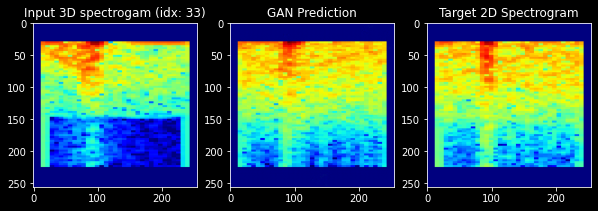

In [22]:
rand_pred = random.randint(0,999)

with Image.open(InferenceFiles[rand_pred]) as img:
  spec_prediction = np.array(img)

with Image.open(ImageFiles_2D[rand_pred]) as img:
  spec_2D = np.array(img)

with Image.open(ImageFiles_3D[rand_pred]) as img:
  spec_3D = np.array(img)

colormap = 'jet'
min_val = -10
max_val = 1

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10,4))
ax[0].imshow(spec_3D, cmap = colormap, vmin=min_val, vmax=max_val)
ax[0].set_title('Input 3D spectrogam (idx: {})'.format(rand_pred))
ax[1].imshow(spec_prediction, cmap = colormap, vmin=min_val, vmax=max_val)
ax[1].set_title('GAN Prediction')
ax[2].imshow(spec_2D, cmap = colormap, vmin=min_val, vmax=max_val)
ax[2].set_title('Target 2D Spectrogram')
plt.show()

# Convert prediction images back to magnitude spectra arrays

In [61]:
start = time.time()

## Parameters from image generation
colormap = 'jet'
min_val = -10
max_val = 1

## Get random prediction
rand_pred = random.randint(0,999)
with Image.open(InferenceFiles[rand_pred]) as img:
  spec_prediction = np.array(img)

## Reshape prediction spectrogram back to proper size
dim_0_repeat = 3
dim_1_repeat = 7

target_dim_0 = 65
target_dim_1 = 33

dim_0_start = 30
dim_1_start = 12

Pred_Spec = spec_prediction[dim_0_start+int(dim_0_repeat/2): (dim_0_repeat*target_dim_0)+dim_0_start+int(dim_0_repeat/2) :dim_0_repeat,
                       dim_1_start+int(dim_1_repeat/2): (dim_1_repeat*target_dim_1)+dim_1_start+int(dim_1_repeat/2) :dim_1_repeat]


## Grab 2D line/trace, 3D trace from filenames
Line_2D = ImageFiles_2D[rand_pred].split('/')[-1].split('_')[1]
trace_2D = ImageFiles_2D[rand_pred].split('/')[-1].split('_')[3].split('.')[0]
trace_3D = ImageFiles_3D[rand_pred].split('/')[-1].split('_')[3].split('.')[0]

color_retrieve = np.zeros((Pred_Spec.shape[0], Pred_Spec.shape[1]))

##!!!!!!! NEED TO VECTORIZE
for i in range(Pred_Spec.shape[0]):
    for j in range(Pred_Spec.shape[1]):
        color_retrieve[i,j] = get_val_color(Pred_Spec[i,j,:-1], matplotlib.cm.get_cmap(colormap))
        
multiplier = np.abs(max_val - min_val)
color_retrieve = (color_retrieve * multiplier) + min_val

Prediction_Mag_Spec = np.exp(color_retrieve)

# plt.imshow(color_retrieve,cmap=colormap, vmin=min_val, vmax=max_val)
# plt.colorbar()

end = time.time()
print("Time to completion (s): ", end-start)

Time to completion (s):  8.350900173187256


# Run GLA on predicted magnitude spectra

In [62]:
## Get 2D and 3D traces, reshape
## Standardardize traces for comparison

Volume2D = "/content/drive/My Drive/RadNET/GAN data/2D/"+Line_2D+".sgy"

with segyio.open(Volume2D, 'r') as segyfile:
    display_line2D = segyio.tools.collect(segyfile.trace[:])
    display_line2D = display_line2D[:,1970:3040]
    GAN_test_trace_2D = display_line2D[int(trace_2D),:]
    
with segyio.open(Volume3D, 'r') as segyfile:
    GAN_test_trace_3D = segyfile.trace[int(trace_3D)]
    
    
scaler2D = StandardScaler()    
scaler3D = StandardScaler()
test_trace_2D_expand = GAN_test_trace_2D.reshape((len(GAN_test_trace_2D), 1))
test_trace_3D_expand = GAN_test_trace_3D.reshape((len(GAN_test_trace_3D), 1))
standardized_2DGAN_trace = scaler2D.fit_transform(test_trace_2D_expand)
standardized_3DGAN_trace = scaler3D.fit_transform(test_trace_3D_expand)

standardized_2DGAN_trace = np.squeeze(standardized_2DGAN_trace)
standardized_3DGAN_trace = np.squeeze(standardized_3DGAN_trace)


# Reshaping performed during image write
standardized_2DGAN_trace = standardized_2DGAN_trace[30:-20]
standardized_3DGAN_trace = standardized_3DGAN_trace[30:-20]


########################################
## Perform GLA on prediction spectrogram
fs = 1 / 0.0000000375     
nperseg = 128        
noverlap = 96
window = signal.hann(nperseg, sym=False)

# Giving 3D trace as starting phase
GAN_signal, _ = griffin_lim(Prediction_Mag_Spec, 300, standardized_3DGAN_trace, fs, nperseg, noverlap, window)

View time series traces

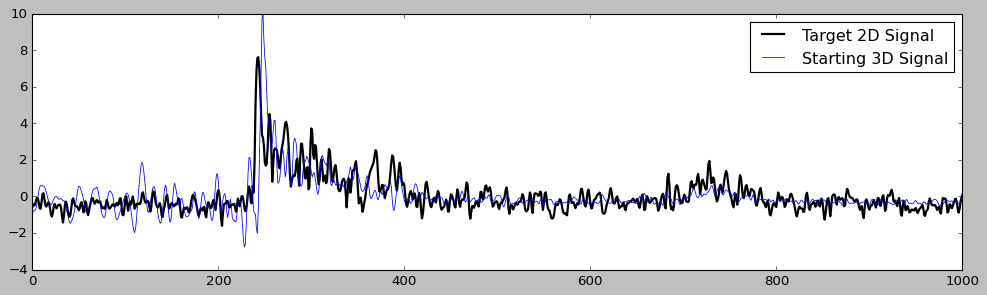

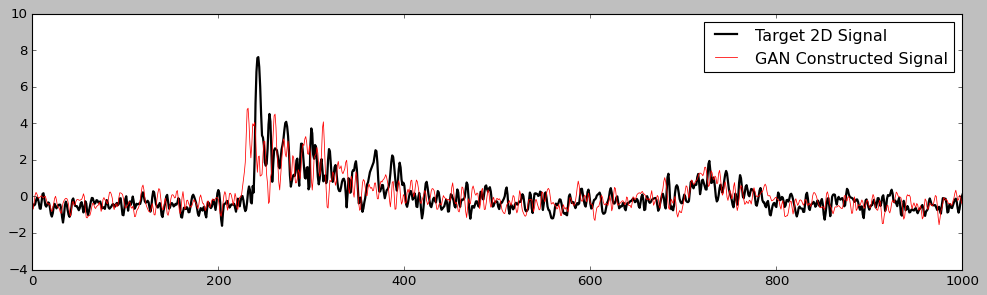

In [65]:
## Plot starting 3D trace and 2D Target
plt.figure(figsize=(15,4))
plt.plot(standardized_2DGAN_trace, color='black', linewidth=2, label='Target 2D Signal')
plt.plot(standardized_3DGAN_trace, color='blue', linewidth=0.7, label='Starting 3D Signal')
plt.xlim(0,1000)
plt.ylim(-4,10)
plt.legend()
plt.show()

## Plot GAN prediction and 2D Target
plt.figure(figsize=(15,4))
plt.plot(standardized_2DGAN_trace, color='black', linewidth=2, label='Target 2D Signal')
plt.plot(GAN_signal, color='red', linewidth=0.7, label='GAN Constructed Signal')
plt.xlim(0,1000)
plt.ylim(-4,10)
plt.legend()
plt.show()